## Read in Data

In [1]:
#Read in data (modify this code as needed for where you have stored your data)
import pandas as pd
from pre_and_post_valuations_data import post_eip_oct_txn_file, october_block_data


df=pd.read_csv(post_eip_oct_txn_file)
bx_df=pd.read_csv(october_block_data)

#Filtering data remove legacy transactions.
df=df[df.transaction_type==2]
df=df.reset_index(drop=True)

## Creating Oracle and Valuation for Tips

In [2]:
#Creating oracle for tips
import numpy as np
min_tip=[]
for i in df.block_number.unique():
    temp_df=df[df.block_number==i]
    min_tip.append(min(temp_df.max_priority_fee_per_gas))
min_gwei=[i/10**9 for i in min_tip]
oracle_tip=[np.percentile(min_gwei[i-100:i-1],60) for i in range(100,len(min_gwei))]

#create tip hash map for the to map block number to recommend tip. Used later on.
tip_dict={}
count=0
for i in df.block_number.unique():
    if count>99:
        tip_dict[i]=oracle_tip[count-100]
    count=count+1

In [3]:
#Creating tip values 
tip=[i/10**9 for i in df.max_priority_fee_per_gas]
values_tip=[(tip[i+100]+1)/(oracle_tip[i]+1) for i in range(len(oracle_tip))]

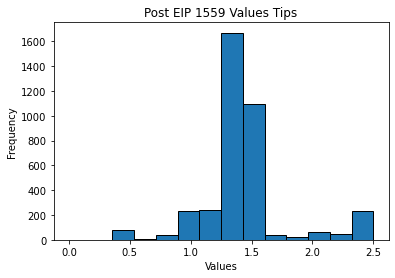

In [4]:
#Plotting Values for tips
import matplotlib.pyplot as plt
bin_list=np.linspace(0,2.5,15)
plt.hist(values_tip,bin_list,ec='black')
plt.title('Post EIP 1559 Values Tips')
plt.xlabel('Values')
plt.ylabel('Frequency');

## Creating Oracle and Valuations for Bids

In [5]:
#Creating oracle for max fee
import numpy as np
import math
import statistics
base_fee_dict=dict(zip(bx_df.number,bx_df.base_fee_per_gas))
max_fee=[]
base_fee=[]
geth_tip=[]
for i in range(len(df)):
    max_fee.append(df.max_fee_per_gas[i]/10**9)
    base_fee.append(base_fee_dict[df.block_number[i]]/10**9)
    if df.block_number[i] in tip_dict.keys():
        geth_tip.append(tip_dict[df.block_number[i]])
    else:
        geth_tip.append(statistics.mean(oracle_tip))
oracle_max=[2*base_fee[i]+geth_tip[i] for i in range(100,len(max_fee))]

In [6]:
#Creating Values
import math
values_max=[max_fee[i+100]/oracle_max[i] for i in range(len(oracle_max))]

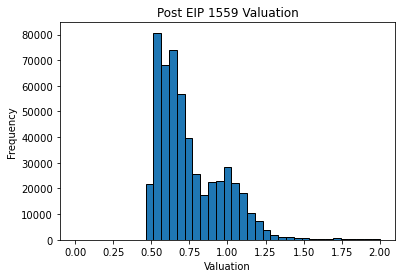

In [7]:
#Plotting Values
import matplotlib.pyplot as plt
bin_list=np.linspace(0,2,40)
plt.hist(values_max,bin_list,ec='black')
plt.title('Post EIP 1559 Valuation')
plt.xlabel('Valuation')
plt.ylabel('Frequency');

## Modelling Valuations (two models for low and high valuation)

In [8]:
#Solving for MLE of 1st gamma distribution
import statistics
import math
values1=[i for i in values_max if i<=0.8]
k_1=0.5/(math.log(statistics.mean(values1))-statistics.mean([math.log(i) for i in values1]))
theta_1=statistics.mean(values1)/k_1
print('The maximum likelihood estimator for k and theta are',round(k_1,4),'and',round(theta_1,4))

The maximum likelihood estimator for k and theta are 59.6849 and 0.0105


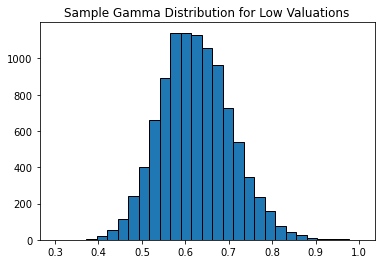

In [9]:
#Graphing the gamma distribution for values
test=np.random.gamma(k_1,theta_1,10000)
bin_list=np.linspace(0.3,1,30)
plt.hist(test,bin_list,ec='black')
plt.title('Sample Gamma Distribution for Low Valuations');

In [10]:
#Solving for MLE of 2nd gamma distribution. Truncation I used was 10
import statistics
import math
values2=[i for i in values_max if i>0.75]
truncate=input('Do you want to truncate the upper ends of data? Input Y or N: ')
if truncate=='Y':
    p_truncate=int(input('What percentile of the data do you want to truncate. Enter an integer between 0 and 100: '))
    r_truncate=round(len(values2)*(1-p_truncate/100))
    values2.sort()
    values2=values2[0:r_truncate]
#r_truncate=np.percentile(values2,100-p_truncate)
#values2=[i for i in values2 if i<r_truncate]
k_2=0.5/(math.log(statistics.mean(values2))-statistics.mean([math.log(i) for i in values2]))
theta_2=statistics.mean(values2)/k_2
print('The maximum likelihood estimator for k and theta are',round(k_2,4),'and',round(theta_2,4))

Do you want to truncate the upper ends of data? Input Y or N: Y
What percentile of the data do you want to truncate. Enter an integer between 0 and 100: 5
The maximum likelihood estimator for k and theta are 19.97 and 0.0506


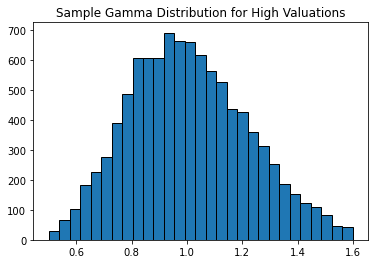

In [11]:
#Graphing the gamma distribution for values
test=np.random.gamma(k_2,theta_2,10000)
bin_list=np.linspace(0.5,1.6,30)
plt.hist(test,bin_list,ec='black')
plt.title('Sample Gamma Distribution for High Valuations');

## Modelling Demand

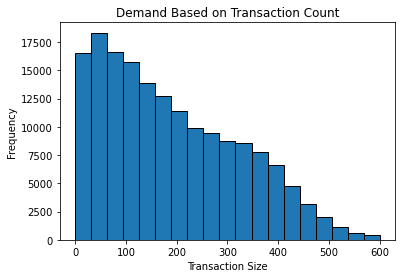

In [12]:
#Graphing demand by using transaction sizes per block. 
import matplotlib.pyplot as plt
bin_list=np.linspace(0,600,20)
plt.hist(bx_df.transaction_count,bin_list,ec='black')
plt.title('Demand Based on Transaction Count')
plt.xlabel('Transaction Size')
plt.ylabel('Frequency');

In [13]:
#Solving for MLE of demand gamma distribution. Truncation used was 5 percent here
import statistics
import math
#The +1 here is just to get rid of zeroes since log of 0 is undefined
demand=[(i+1) for i in bx_df.transaction_count]
truncate=input('Do you want to truncate the data? Input Y or N: ')
if truncate=='Y':
    p_truncate=int(input('What percentile of the data do you want to truncate. Enter an integer between 0 and 100: '))
    r_truncate=round(len(demand)*(1-p_truncate/100))
    demand.sort()
    demand=demand[0:r_truncate]
k_d=0.5/(math.log(statistics.mean(demand))-statistics.mean([math.log(i) for i in demand]))
theta_d=statistics.mean(demand)/k_d
print('The maximum likelihood estimator for k and theta are',round(k_d,4),'and',round(theta_d,4))

Do you want to truncate the data? Input Y or N: Y
What percentile of the data do you want to truncate. Enter an integer between 0 and 100: 5
The maximum likelihood estimator for k and theta are 1.3247 and 134.6425


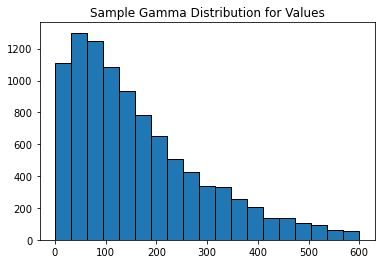

In [14]:
#Graphing the gamma distribution for values
import numpy as np
test=np.random.gamma(k_d,theta_d,10000)
bin_list=np.linspace(0,600,20)
plt.hist(test,bin_list,ec='black')
plt.title('Sample Gamma Distribution for Values');

## Creating Simulations

In [15]:
#Create Simulation Data
import random

#Set up

sim=int(input('Simulation Size = '))
d=8
T=15000000 #15 million is the target gas gas used

#Set up intital base fee
b_int=np.random.randint(0,len(bx_df)-100)
base_fee_simulation=[i/10**9 for i in bx_df.base_fee_per_gas[b_int:b_int+100]]
base_fee_simulation=[statistics.mean(base_fee_simulation)]

#Set up initial market price
m_int=np.random.randint(0,len(oracle_max)-100)
market_bid=oracle_max[m_int:m_int+100]
temp_market=np.percentile(market_bid[-100:],60)

for i in range(sim):
    #Set up
    total_gas=0
    bx_size=round(np.random.gamma(k_d,theta_d,1)[0])
    gas_used=random.sample(list(df.gas),bx_size)
    which_dist=random.randint(1,3)
    if which_dist==3:
        bids=np.random.gamma(k_2,theta_2,bx_size)
    else:
        bids=np.random.gamma(k_1,theta_1,bx_size)
    bids=[j*temp_market for j in bids]
    bids=sorted(bids,reverse=True)
    for k in range(bx_size):
        if total_gas+gas_used[k]<=30000000 and bids[k]>base_fee_simulation[-1]:
            total_gas=total_gas+gas_used[k]
    base_fee_simulation.append(base_fee_simulation[-1]*(1+(total_gas-T)/(d*T)))

Simulation Size = 1000


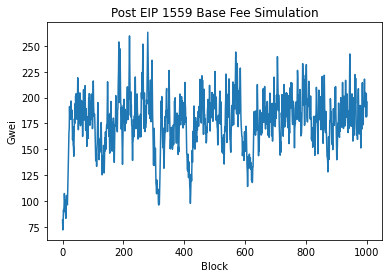

In [16]:
#Plot Simulation
import matplotlib.pyplot as plt
plt.plot(base_fee_simulation);
plt.title('Post EIP 1559 Base Fee Simulation')
plt.xlabel('Block')
plt.ylabel('Gwei');

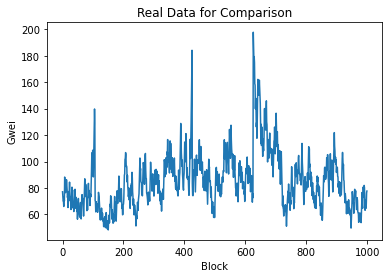

In [17]:
#Comparison, using data without spikes
no_spikes=[i/10**9 for i in bx_df.base_fee_per_gas if i/10**9<=200]
X=np.random.randint(0,len(no_spikes)-1000)
real=no_spikes[X:X+1000]
plt.plot(real)
plt.ylabel('Gwei')
plt.xlabel('Block')
plt.title('Real Data for Comparison');

## QQ Plots

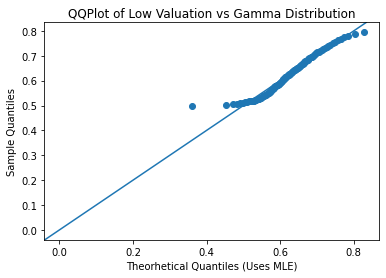

In [18]:
theory=np.random.gamma(k_1,theta_1,10000)
X=[]
Y=[]
for i in range(100):
    X.append(np.percentile(theory,i))
    Y.append(np.percentile(values1,i))
plt.scatter(X,Y)
plt.axline([0,0],slope=1)
plt.title('QQPlot of Low Valuation vs Gamma Distribution')
plt.xlabel('Theorhetical Quantiles (Uses MLE)')
plt.ylabel('Sample Quantiles');

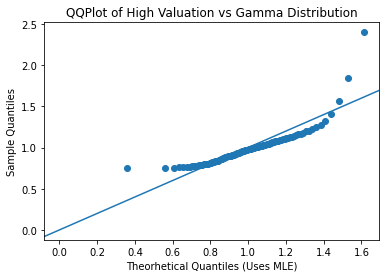

In [19]:
theory=np.random.gamma(k_2,theta_2,10000)
X=[]
Y=[]
for i in range(100):
    X.append(np.percentile(theory,i))
    Y.append(np.percentile(values2,i))
plt.scatter(X,Y)
plt.axline([0,0],slope=1)
plt.title('QQPlot of High Valuation vs Gamma Distribution')
plt.xlabel('Theorhetical Quantiles (Uses MLE)')
plt.ylabel('Sample Quantiles');

Text(0, 0.5, 'Sample Quantiles')

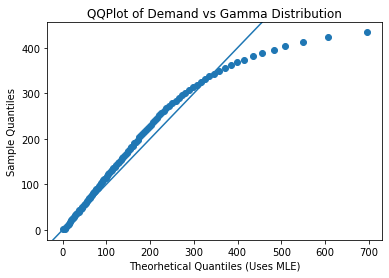

In [20]:
import statistics
theory=np.random.gamma(k_d,theta_d,10000)
X=[]
Y=[]
for i in range(100):
    X.append(np.percentile(theory,i))
    Y.append(np.percentile(demand,i))
plt.scatter(X,Y)
plt.axline([0,0],slope=1)
plt.title('QQPlot of Demand vs Gamma Distribution')
plt.xlabel('Theorhetical Quantiles (Uses MLE)')
plt.ylabel('Sample Quantiles')

## ARIMA

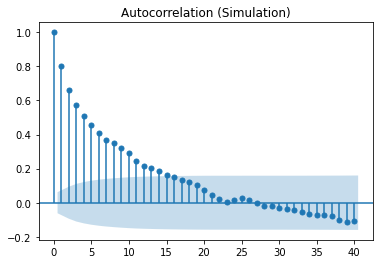

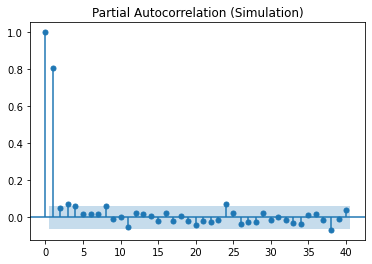

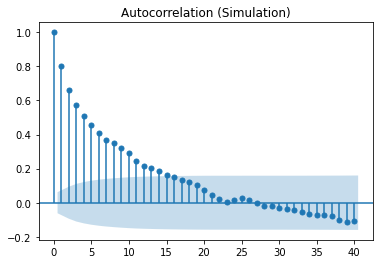

In [21]:
#Run simulation before running this code (P.S not sure why ACF graph appears twice)
import statsmodels.api as sm
sm.graphics.tsa.plot_pacf(base_fee_simulation,lags=40,title='Partial Autocorrelation (Simulation)')
sm.graphics.tsa.plot_acf(base_fee_simulation,lags=40,title='Autocorrelation (Simulation)')

In [22]:
#Creating simulation ARIMA model
from statsmodels.tsa.arima.model import ARIMA
model_sim= ARIMA(base_fee_simulation, order=(2,0,0))
model_sim_fit=model_sim.fit()
model_sim_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1001
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -4172.114
Date:                Mon, 03 Jan 2022   AIC                           8352.227
Time:                        12:30:59   BIC                           8371.862
Sample:                             0   HQIC                          8359.689
                               - 1001                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        175.5921      2.755     63.731      0.000     170.192     180.992
ar.L1          0.7685      0.033     23.301      0.000       0.704       0.833
ar.L2          0.0573      0.032      1.801      0.072      -0.005       0.120
sigma2       243.9472     18.403     13.256      0.000     207.878     280.017
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                57.06
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                             0.30
Prob(H) (two-sided):                  0.49   Kurtosis:                         2.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

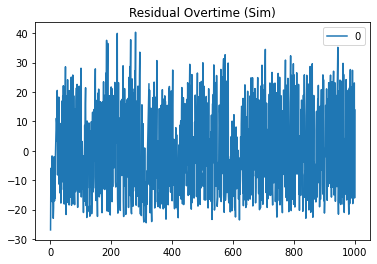

In [23]:
#Plotting residuals overtime
residuals = pd.DataFrame(model_sim_fit.resid)
residuals[1:].plot()
plt.title('Residual Overtime (Sim)');

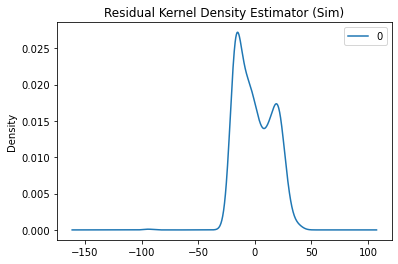

In [24]:
#Plotting KDE of residuals
residuals.plot(kind='kde')
plt.title('Residual Kernel Density Estimator (Sim)');

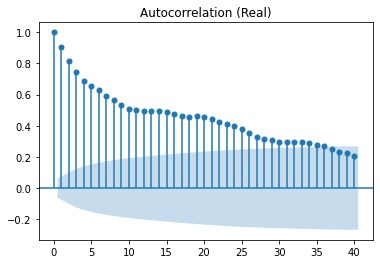

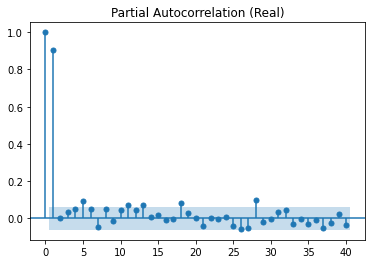

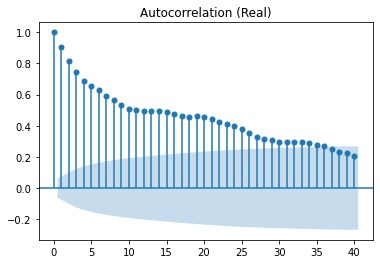

In [25]:
import statsmodels.api as sm
sm.graphics.tsa.plot_pacf(real,lags=40,title='Partial Autocorrelation (Real)')
sm.graphics.tsa.plot_acf(real,lags=40,title='Autocorrelation (Real)')

In [26]:
#Creating real ARIMA model
from statsmodels.tsa.arima.model import ARIMA
model_sim= ARIMA(real, order=(2,0,0))
model_sim_fit=model_sim.fit()
model_sim_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -3609.200
Date:                Mon, 03 Jan 2022   AIC                           7226.400
Time:                        12:31:01   BIC                           7246.031
Sample:                             0   HQIC                          7233.862
                               - 1000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         85.5573      3.785     22.604      0.000      78.139      92.976
ar.L1          0.8988      0.030     29.856      0.000       0.840       0.958
ar.L2          0.0049      0.034      0.144      0.885      -0.061       0.071
sigma2        79.7728      0.991     80.482      0.000      77.830      81.716
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             94622.46
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                             1.62
Prob(H) (two-sided):                  0.82   Kurtosis:                        50.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

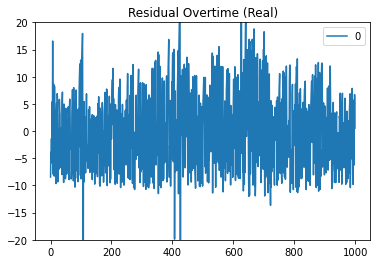

In [27]:
#Plotting residuals overtime
residuals = pd.DataFrame(model_sim_fit.resid)
residuals.plot()
plt.ylim(-20,20)
plt.title('Residual Overtime (Real)');

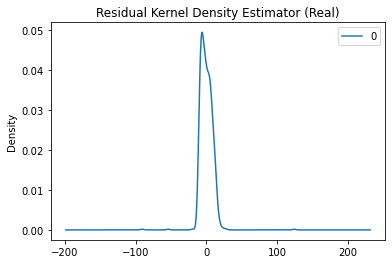

In [28]:
#Plotting KDE of residuals
residuals.plot(kind='kde')
plt.title('Residual Kernel Density Estimator (Real)');